In [1]:
# import required libraries
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import time as time

# Import mlcompute module to use the optional set_mlc_device API for device selection with ML Compute.
from tensorflow.python.compiler.mlcompute import mlcompute

# Select processing device.
mlcompute.set_mlc_device(device_name='gpu') # Available options are 'cpu', 'gpu', and 'any'.

# Remove apple to tensorflow comparison warnings
# note these warning do not affect the model, they are removed for visual purposes
tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
# download dataset and initialise test/train
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [3]:
# measure time taken for model to run and to run image technique
start = time.time()

In [4]:
# apply image technique to dataset
harris_train = np.empty((50000, 32, 32))
harris_test = np.empty((10000, 32, 32))

for index, image in enumerate(train_images):
    gray = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    harris_train[index] = cv.cornerHarris(gray, 2, 3, 0.04)
    harris_train[index] = cv.dilate(harris_train[index], None)
    image[harris_train[index] > 0.01 * harris_train[index].max()] =[0, 0, 255]
    
for index, image in enumerate(test_images):
    gray = cv.cvtColor((image * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    harris_test[index] = cv.cornerHarris(gray, 2, 3, 0.04)
    harris_test[index] = cv.dilate(harris_test[index], None)
    # choose threshold
    image[harris_test[index] > 0.01 * harris_test[index].max()] =[0, 0, 255]
    
# add gray scale dimension
harris_train = harris_train[..., np.newaxis]
harris_test = harris_test[..., np.newaxis]

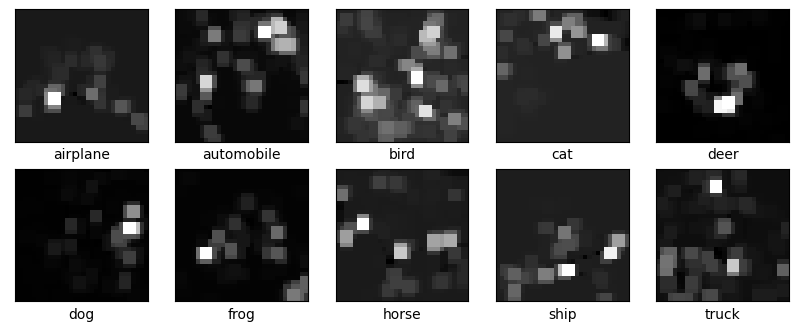

In [5]:
# verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

image_class_index = [harris_train[30], harris_train[5], harris_train[6], harris_train[9], harris_train[3],
                     harris_train[27], harris_train[0], harris_train[7], harris_train[8], harris_train[1]]

plt.figure(figsize=(10,10))
for i in range(len(image_class_index)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_class_index[i], cmap='gray')
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[i])
plt.show()

In [6]:
# import model
model = models.load_model("CNN_gray")

# compile and train model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'], run_eagerly=False)

history = model.fit(harris_train, train_labels, epochs=10, 
                    validation_data=(harris_test, test_labels))

end = time.time()

Epoch 1/10
1563/1563 [==============================] - 56s 35ms/step - loss: 40027.3009 - accuracy: 0.1091 - val_loss: 2.4833 - val_accuracy: 0.1004
Epoch 2/10
1563/1563 [==============================] - 51s 33ms/step - loss: 2.4356 - accuracy: 0.0998 - val_loss: 2.3693 - val_accuracy: 0.1004
Epoch 3/10
1563/1563 [==============================] - 53s 34ms/step - loss: 2.3206 - accuracy: 0.0982 - val_loss: 2.3391 - val_accuracy: 0.0996
Epoch 4/10
1563/1563 [==============================] - 52s 33ms/step - loss: 2.3036 - accuracy: 0.0988 - val_loss: 2.3404 - val_accuracy: 0.1008
Epoch 5/10
1563/1563 [==============================] - 52s 33ms/step - loss: 2.3027 - accuracy: 0.1003 - val_loss: 2.3113 - val_accuracy: 0.1005
Epoch 6/10
1563/1563 [==============================] - 52s 33ms/step - loss: 2.3030 - accuracy: 0.1012 - val_loss: 2.3123 - val_accuracy: 0.0999
Epoch 7/10
1563/1563 [==============================] - 52s 33ms/step - loss: 2.5711 - accuracy: 0.0968 - val_loss: 2.30

Validation set results
313/313 - 4s - loss: 2.3027 - accuracy: 0.1000
Total time taken to classify: 8.79 minutes


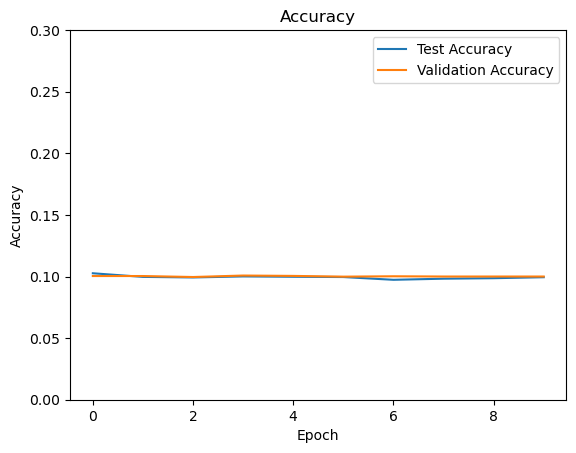

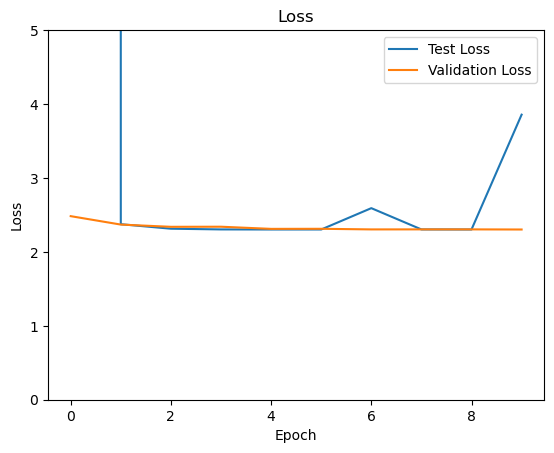

In [8]:
# test model and print results
print("Validation set results")
test_loss, test_acc = model.evaluate(harris_test, test_labels, verbose = 2)

# print total time take
minutes = (end - start) / 60
print("Total time taken to classify: {:.2f}".format(minutes), "minutes")

# Plot the accuracy
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='Test Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, .3])
plt.legend(loc='upper right')
plt.show()

# Plot the loss
plt.title("Loss")
plt.plot(history.history['loss'], label='Test Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='upper right')
plt.show()